In [12]:
import pymysql
import pandas as pd

In [2]:
class preprocessor:
    def __init__(self):
        pass
    

In [358]:
order_col_names = ['id', 'time', 
                   'ask_1', 'ask_1_amt', 'bid_1', 'bid_1_amt', 'ask_2', 'ask_2_amt', 'bid_2', 'bid_2_amt', 
                   'ask_3', 'ask_3_amt', 'bid_3', 'bid_3_amt', 'ask_4', 'ask_4_amt', 'bid_4', 'bid_4_amt', 
                   'ask_5', 'ask_5_amt', 'bid_5', 'bid_5_amt']
order_col_names_2 = ['id', 'time', 
                      'ask_1', 'ask_1_amt', 'ask_1_before', 'bid_1', 'bid_1_amt', 'bid_1_before', 
                      'ask_2', 'ask_2_amt', 'ask_2_before', 'bid_2', 'bid_2_amt', 'bid_2_before', 
                      'ask_3', 'ask_3_amt', 'ask_3_before', 'bid_3', 'bid_3_amt', 'bid_3_before', 
                      'ask_4', 'ask_4_amt', 'ask_4_before', 'bid_4', 'bid_4_amt', 'bid_4_before', 
                      'ask_5', 'ask_5_amt', 'ask_5_before', 'bid_5', 'bid_5_amt', 'bid_5_before']
trans_col_names = ['id', 'time', 'price', 'amount']

# def get_col_names(cur, table_name):
#     ''' get col namess
#     '''
#     q = f'''DESCRIBE {table_name}'''
#     cur.execute(q)
#     cols = cur.fetchall()
    
#     return [col[0] for col in cols]

def get_dbs(cur):
    q = '''SHOW DATABASES'''
    cur.execute(q)
    res = cur.fetchall()
    
    return [r[0] for r in res]

def get_table_names(cur):
    q = '''SHOW TABLES'''
    cur.execute(q)
    tables = cur.fetchall()
    
    return [t[0] for t in tables]

def read_table_by_info(cur, date, table_type, code):
    q = f'''SELECT * FROM {date}_{table_type}_{code}'''
    cur.execute(q)
    rows = cur.fetchall()
    
    return rows

def read_table_by_name(table_name):
    q = f'''SELECT * FROM {table_name}'''
    cur.execute(q)
    rows = cur.fetchall()
    
    return rows

def extract_combinations(tables):
    combi = []
    for col in zip(*[table.split('_') for table in tables]):
        combi.append(set(col))
    
    return combi

def get_order_tables_names(cur):
    tables = get_table_names(cur)
    return [t for t in tables if 'order' in t]

def get_trans_tables_names(cur):
    tables = get_table_names(cur)
    return [t for t in tables if 'trans' in t]

def get_table_df(table_name):
    rows = read_table_by_name(table_name)
    df = pd.DataFrame(rows)
    if 'order' in table_name:
        if len(df.columns) == len(order_col_names):
            df.columns = order_col_names
        else:
            df.columns = order_col_names_2
        df.drop(columns='id', inplace=True)
        
    elif 'trans' in table_name:
        df.columns = trans_col_names
        df.drop(columns='id', inplace=True)
    
    return df

# for trans
def get_trans_vpin(trans_df, max_capa=20000, window=5):
    '''
    maybe need cut out by time (0900~1520)
    proxy of PIN, volatility
    '''
    
    amounts = trans_df['amount']
    cur_i, buy, sell, b_cnt, s_cnt = 1, 0, 0, 0, 0
    buckets = []

    # vol buckets
    while len(df) > cur_i:
        if amounts[cur_i] >=0:
            buy += amounts[cur_i]
            b_cnt += 1
        else:
            sell += amounts[cur_i]
            s_cnt += 1

        if buy + (-sell) >= max_capa:
            buckets.append((cur_i, buy, sell, b_cnt, s_cnt))
            buy, sell, b_cnt, s_cnt = 0, 0, 0, 0
        cur_i += 1

    vol_buckets = pd.DataFrame(buckets)
    vol_buckets.columns = ['trans_idx', 'buy', 'sell', 'buy_cnt', 'sell_cnt']
    
    # vpin
#     vpin = abs(vol_buckets['buy'].rolling(window).sum() + vol_buckets['sell'].rolling(window).sum()) / (max_capa * window)
    vpin = abs(vol_buckets['buy'] + vol_buckets['sell']) / (vol_buckets['buy'] - vol_buckets['sell'])

    vol_buckets['vpin'] = vpin
    
    return vol_buckets

# for order
def get_sobi(df):
    vol_ask = df[f'ask_1_amt'] + df[f'ask_2_amt'] + df[f'ask_3_amt'] + df[f'ask_4_amt'] + df[f'ask_5_amt']
    vol_bid = df[f'bid_1_amt'] + df[f'bid_2_amt'] + df[f'bid_3_amt'] + df[f'bid_4_amt'] + df[f'bid_5_amt']

    tmp_ask = [abs(df[f'ask_{i}'] * df[f'ask_{i}_amt']) for i in range(1, 6)]
    tmp_bid = [abs(df[f'bid_{i}'] * df[f'bid_{i}_amt']) for i in range(1, 6)]

    total_ask = tmp_ask[0] + tmp_ask[1] + tmp_ask[2] + tmp_ask[3] + tmp_ask[4]
    total_bid = tmp_bid[0] + tmp_bid[1] + tmp_bid[2] + tmp_bid[3] + tmp_bid[4]

    ask_vwap = total_ask / vol_ask
    bid_vwap = total_bid / vol_bid
    
    
    mid_vwap = (ask_vwap + bid_vwap) / 2
    mid_price = (abs(df['ask_1']) * df['ask_1_amt'] + abs(df['bid_1']) * df['bid_1_amt']) / (df['bid_1_amt'] + df['ask_1_amt'])
    
    return mid_vwap, mid_price

# for candle

In [4]:
conn = pymysql.connect(user='root', passwd='0000', host='localhost', db='kiwoom')
cur = conn.cursor()

In [7]:
dbs = get_dbs(cur)
tables = get_table_names(cur)
combis = extract_combinations(tables)
# col_names = get_col_names(cur, tables[0])
trans_tables = get_trans_tables_names(cur)
order_tables = get_order_tables_names(cur)

In [189]:
df = get_table_df(order_tables[5])

In [34]:
df

,time,ask_1,ask_1_amt,bid_1,bid_1_amt,ask_2,ask_2_amt,bid_2,bid_2_amt,ask_3,...,bid_3,bid_3_amt,ask_4,ask_4_amt,bid_4,bid_4_amt,ask_5,ask_5_amt,bid_5,bid_5_amt
0,2022-08-08 09:01:39,-194000,3097,-193500,4411,194500,4944,-193000,7405,195000,...,-192500,15078,195500,8146,-192000,19548,196000,10929,-191500,21612
1,2022-08-08 09:01:40,-194000,3104,-193500,4488,194500,4944,-193000,7406,195000,...,-192500,15078,195500,8146,-192000,19548,196000,10929,-191500,21612
2,2022-08-08 09:01:41,-194000,3098,-193500,4337,194500,4925,-193000,7456,195000,...,-192500,15078,195500,8176,-192000,19548,196000,10929,-191500,21618
3,2022-08-08 09:01:42,-194000,3284,-193500,4422,194500,4945,-193000,7454,195000,...,-192500,15082,195500,8176,-192000,19552,196000,10929,-191500,21618
4,2022-08-08 09:01:43,-194000,3282,-193500,4455,194500,4945,-193000,7454,195000,...,-192500,15087,195500,8176,-192000,19552,196000,10929,-191500,21618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40211,2022-08-08 15:30:20,196000,23545,195500,14524,196500,28187,195000,10478,197000,...,194500,8031,0,0,0,0,0,0,0,0
40212,2022-08-08 15:30:21,196000,23515,195500,14524,196500,28187,195000,10478,197000,...,194500,8031,0,0,0,0,0,0,0,0
40213,2022-08-08 15:30:21,196000,23515,195500,14524,196500,28187,195000,10478,197000,...,194500,8031,0,0,0,0,0,0,0,0
40214,2022-08-08 15:30:23,196000,23515,195500,14524,196500,28187,195000,10478,197000,...,194500,8031,197500,15834,-194000,12459,198000,18642,-193500,5946


In [32]:
vb = get_trans_vpin(df, max_capa=5000, window=1)

TypeError: get_order_tables_names() got an unexpected keyword argument 'max_capa'

<BarContainer object of 96 artists>

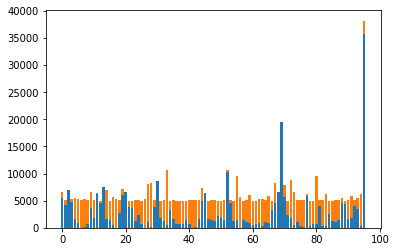

In [29]:
import numpy as np
import matplotlib.pyplot as plt

buckets = np.array(vb)
plt.bar(range(len(buckets)), buckets[:, 1])
plt.bar(range(len(buckets)), -buckets[:, 2], bottom=buckets[:, 1])


<BarContainer object of 96 artists>

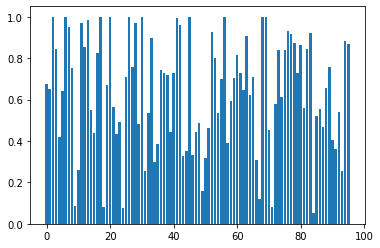

In [30]:
plt.bar(range(len(vb)), vb['vpin'])

In [31]:
vb[vb['vpin']>.7]

,trans_idx,buy,sell,buy_cnt,sell_cnt,vpin
2,193,6882,-9,36,5,0.997388
3,253,4839,-405,41,19,0.845538
6,472,2,-5201,2,18,0.999231
7,532,131,-5099,7,53,0.949904
8,612,622,-4430,18,62,0.753761
11,792,6248,-99,6,1,0.968804
12,851,4644,-364,13,46,0.854633
13,917,7452,-68,47,19,0.981915
16,1240,503,-5227,43,62,0.824433
17,1250,0,-5396,0,10,1.000000


In [19]:
import matplotlib.pyplot as plt

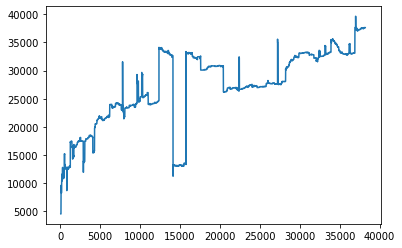

In [71]:
plt.plot(abs(df['ask_2_amt'][100:-2000]))

In [74]:
df

,time,ask_1,ask_1_amt,bid_1,bid_1_amt,ask_2,ask_2_amt,bid_2,bid_2_amt,ask_3,...,bid_3,bid_3_amt,ask_4,ask_4_amt,bid_4,bid_4_amt,ask_5,ask_5_amt,bid_5,bid_5_amt
0,2022-08-08 09:01:39,-194000,3097,-193500,4411,194500,4944,-193000,7405,195000,...,-192500,15078,195500,8146,-192000,19548,196000,10929,-191500,21612
1,2022-08-08 09:01:40,-194000,3104,-193500,4488,194500,4944,-193000,7406,195000,...,-192500,15078,195500,8146,-192000,19548,196000,10929,-191500,21612
2,2022-08-08 09:01:41,-194000,3098,-193500,4337,194500,4925,-193000,7456,195000,...,-192500,15078,195500,8176,-192000,19548,196000,10929,-191500,21618
3,2022-08-08 09:01:42,-194000,3284,-193500,4422,194500,4945,-193000,7454,195000,...,-192500,15082,195500,8176,-192000,19552,196000,10929,-191500,21618
4,2022-08-08 09:01:43,-194000,3282,-193500,4455,194500,4945,-193000,7454,195000,...,-192500,15087,195500,8176,-192000,19552,196000,10929,-191500,21618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40211,2022-08-08 15:30:20,196000,23545,195500,14524,196500,28187,195000,10478,197000,...,194500,8031,0,0,0,0,0,0,0,0
40212,2022-08-08 15:30:21,196000,23515,195500,14524,196500,28187,195000,10478,197000,...,194500,8031,0,0,0,0,0,0,0,0
40213,2022-08-08 15:30:21,196000,23515,195500,14524,196500,28187,195000,10478,197000,...,194500,8031,0,0,0,0,0,0,0,0
40214,2022-08-08 15:30:23,196000,23515,195500,14524,196500,28187,195000,10478,197000,...,194500,8031,197500,15834,-194000,12459,198000,18642,-193500,5946


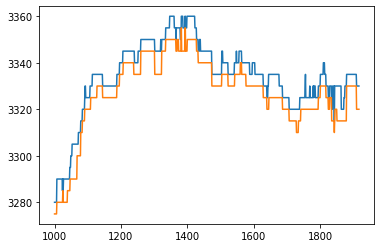

In [191]:
plt.plot(df['ask_1'][1000:-1000])
plt.plot(df['bid_1'][1000:-1000])

In [235]:
get_table_names(cur)

['20220808_order_005380',
 '20220808_order_005930',
 '20220808_order_066570',
 '20220808_trans_005380',
 '20220808_trans_005930',
 '20220808_trans_066570',
 '20220809_order_001770',
 '20220809_order_002290',
 '20220809_order_002690',
 '20220809_order_005670',
 '20220809_order_008370',
 '20220809_order_008470',
 '20220809_order_009140',
 '20220809_order_010420',
 '20220809_order_010640',
 '20220809_order_011420',
 '20220809_trans_001770',
 '20220809_trans_002290',
 '20220809_trans_002690',
 '20220809_trans_005670',
 '20220809_trans_008370',
 '20220809_trans_008470',
 '20220809_trans_009140',
 '20220809_trans_010420',
 '20220809_trans_010640',
 '20220809_trans_011420',
 '20220810_order_001770',
 '20220810_order_002290',
 '20220810_order_002690',
 '20220810_order_005670',
 '20220810_order_008370',
 '20220810_order_008470',
 '20220810_order_009140',
 '20220810_order_010420',
 '20220810_order_010640',
 '20220810_order_011420',
 '20220810_trans_001770',
 '20220810_trans_002290',
 '20220810_t

In [245]:
trans = get_table_df('20220818_trans_001770')

In [362]:
order = get_table_df('20220818_order_001770')

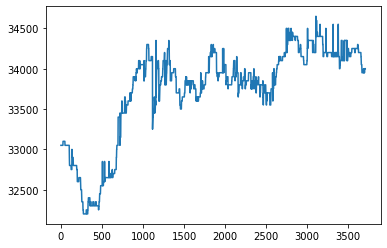

In [262]:
plt.plot(abs(order['bid_1']))

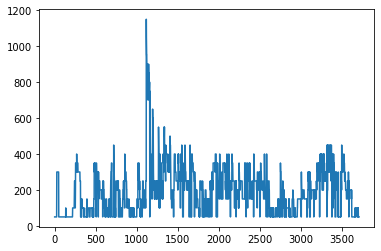

In [370]:
plt.plot(abs(order['ask_1'])-abs(order['bid_1']))